In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gender-odb/gender.csv


In [2]:
import time
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier

In [3]:
%%time

data1 = pd.read_csv('/kaggle/input/gender-odb/gender.csv', usecols=['long_hair', 'forehead_width_cm', 'forehead_height_cm',
                                       'forehead_width_mm', 'forehead_width_conventional_units',
                                       'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long',
                                       'gender'],index_col=False)
data2 = pd.read_csv('/kaggle/input/gender-odb/gender.csv', usecols=['long_hair.1', 'forehead_width_cm.1', 'forehead_height_cm.1',
                                       'forehead_width_mm.1', 'forehead_width_conventional_units.1',
                                       'nose_wide.1', 'nose_long.1', 'lips_thin.1', 'distance_nose_to_lip_long.1',                                       'gender.1'],index_col=False)


CPU times: user 26.4 ms, sys: 9.09 ms, total: 35.5 ms
Wall time: 52.2 ms


In [4]:
data1.head()

,long_hair,forehead_width_cm,forehead_height_cm,forehead_width_mm,forehead_width_conventional_units,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,0.704275,11.8,6.1,118.0,0.025806,0.895614,0.477485,0.841261,0.902628,NaN
1,0.118690,14.0,5.4,140.0,0.167742,0.202520,0.186825,0.719697,0.309122,NaN
2,0.203894,11.8,6.3,118.0,0.025806,0.892793,0.723152,0.725821,0.720640,NaN
3,0.386228,14.4,6.1,144.0,0.193548,0.024963,0.562005,0.831515,0.770379,NaN
4,0.564020,13.5,5.9,135.0,0.135484,0.415389,0.063705,0.211584,0.157217,NaN


In [5]:
data2.columns = ['long_hair', 'forehead_width_cm', 'forehead_height_cm',
                                       'forehead_width_mm', 'forehead_width_conventional_units',
                                       'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long',
                                       'gender']
data2.head()

,long_hair,forehead_width_cm,forehead_height_cm,forehead_width_mm,forehead_width_conventional_units,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,0.818018,11.5,5.8,115.0,0.006452,0.137806,0.402620,0.167844,0.188913,Female
1,0.995941,15.2,5.8,152.0,0.245161,0.570656,0.980237,0.811487,0.967540,Male
2,0.633806,15.4,5.7,154.0,0.258065,0.709777,0.365825,0.933026,0.646992,Male
3,0.795792,13.0,6.9,130.0,0.103226,0.883454,0.399733,0.595028,0.822491,Male
4,0.915185,14.2,5.8,142.0,0.180645,0.652973,0.735543,0.553571,0.532910,Male


In [6]:
data = pd.concat([data1, data2], ignore_index=True)

In [7]:
data[['nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'long_hair']] = data[['nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'long_hair']].round()

In [8]:
data["gender"].value_counts()

Female    2006
Male      1994
Name: gender, dtype: int64

In [9]:
data.isnull().sum()

long_hair                              29
forehead_width_cm                      29
forehead_height_cm                     29
forehead_width_mm                      29
forehead_width_conventional_units      29
nose_wide                              29
nose_long                              29
lips_thin                              29
distance_nose_to_lip_long              29
gender                               1030
dtype: int64

In [10]:
data = data[data['distance_nose_to_lip_long'].notnull()]

In [11]:
pred_x = data[:1001].drop(columns = 'gender')

# EDA

# Model

In [12]:
X = data[1001:].drop(columns = 'gender')
y = data[1001:]['gender'].replace({"Female":1,"Male":0})

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
model = XGBClassifier(learning_rate=0.01).fit(X_train, y_train)
y_pred = model.predict(X_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:35:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


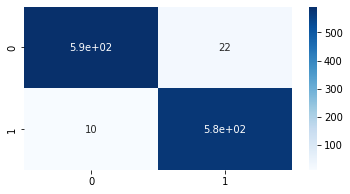

In [15]:
plt.rcParams["figure.figsize"] = (6,3)
ax = plt.axes()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")
plt.show()

In [16]:
pr, rc, fs, sup = metrics.precision_recall_fscore_support(y_test, y_pred, average='macro')
results = {"Accuracy": round(metrics.accuracy_score(y_test, y_pred), 4),
                              "Precision": round(pr, 4), "Recall":round(rc, 4), "FScore":round(fs, 4)}
results

{'Accuracy': 0.9733, 'Precision': 0.9733, 'Recall': 0.9736, 'FScore': 0.9733}

No Skill: ROC AUC=0.500
XGBClassifier: ROC AUC=0.996


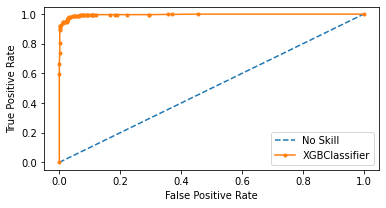

In [17]:
y_prob = model.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
y_prob = y_prob[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_prob)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBClassifier: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_prob)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBClassifier')

# axis labels
plt.rcParams["figure.figsize"] = (16,9)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

In [18]:
pred_y = model.predict(pred_x)
res = pd.DataFrame(pred_y, columns = ['gender']).replace({1: "Female",0 : "Male"})
res.to_csv('result.csv',index=False)